# Simulating a model with MaBoSS

We wish to develop a model that can explain the mechanisms by which some cell lines mutated for BRAF respond well to Chek1 inhibitors

In [1]:
%matplotlib inline
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ginsim
import biolqm
import maboss
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states

## GINsim

In [2]:
lqm = biolqm.load("Charite.zginml")
fps = biolqm.fixpoints(lqm)
print(len(fps), "fixpoints")
pd.DataFrame(fps)

17 fixpoints


Proliferation  Senescence  Apoptosis  Mitotic_Catastrophe  Survival  FGFR  \
0               0           0          0                    0         0     0   
1               0           0          0                    0         1     0   
2               0           0          0                    0         1     0   
3               0           0          0                    0         1     0   
4               0           0          0                    0         1     0   
5               0           0          0                    0         1     1   
6               0           0          0                    0         1     1   
7               0           0          0                    0         1     1   
8               0           0          0                    0         1     1   
9               0           1          1                    0         0     0   
10              0           1          1                    0         0     0   
11              0           1          1                    0         0     0   
12              0           1          1                    0         0     0   
13              1           0          0                    0         0     0   
14              1           0          0                    1         0     0   
15              1           0          0                    1         0     1   
16              1           0          0                    1         0     1   

    EGF  TGFb  DSB_SSB  RAS  ...  PKMYT1  NFkB  PLK1  CLPSN  CASP3  CHUK  \
0     0     0        0    0  ...       0     0     0      0      0     0   
1     0     1        0    0  ...       0     1     1      0      0     0   
2     0     1        1    0  ...       0     1     1      0      0     0   
3     1     1        0    1  ...       0     1     1      0      0     0   
4     1     1        1    1  ...       0     1     1      0      0     0   
5     0     1        0    1  ...       0     1     1      0      0     0   
6     0     1        1    1  ...       0     1     1      0      0     0   
7     1     1        0    1  ...       0     1     1      0      0     0   
8     1     1        1    1  ...       0     1     1      0      0     0   
9     0     0        0    0  ...       0     0     0      1      1     0   
10    0     0        1    0  ...       0     0     0      1      1     0   
11    0     1        0    0  ...       1     0     0      1      1     0   
12    0     1        1    0  ...       1     0     0      1      1     0   
13    0     0        0    0  ...       0     0     0      0      0     0   
14    1     0        1    1  ...       0     0     1      0      0     1   
15    0     0        1    1  ...       0     0     1      0      0     1   
16    1     0        1    1  ...       0     0     1      0      0     1   

    TAK1  MYC  RS  CDC6  
0      0    0   0     0  
1      1    1   0     0  
2      1    1   0     0  
3      1    1   0     0  
4      1    1   0     0  
5      1    1   0     0  
6      1    1   0     0  
7      1    1   0     0  
8      1    1   0     0  
9      0    0   0     0  
10     0    0   0     0  
11     1    0   0     0  
12     1    0   0     0  
13     0    0   0     0  
14     0    1   0     0  
15     0    1   0     0  
16     0    1   0     0  

[17 rows x 48 columns]

In [3]:
# Getting the list of nodes
nodes = list(fps[0].keys())

# Building a 2D numpy array with the nodes order defined above, with each fixpoint value
data = np.array([[fp[node] for node in nodes] for fp in fps])

# The array is XX fixpoints * XX nodes
data.shape

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)

# Getting the new coordinates
X_pca = pca.transform(data)

Text(0, 0.5, 'PC2: 17.00% variance explained')

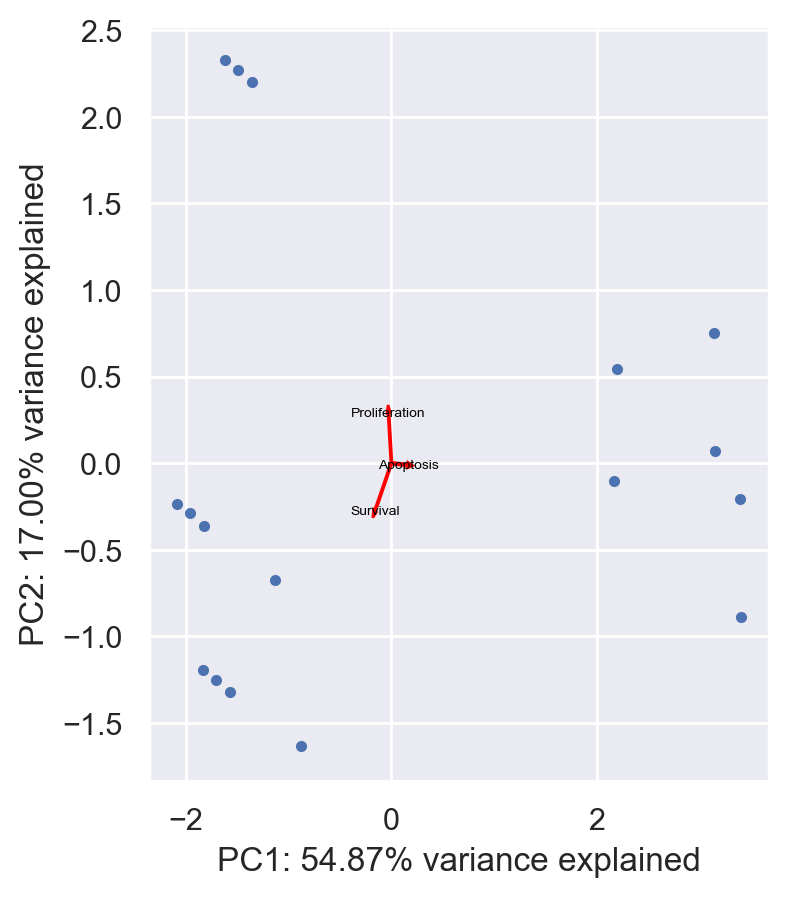

In [4]:
# Plotting the steady states
plt.figure(figsize=(4, 5), dpi=200)
plt.plot(X_pca[:, 0], X_pca[:, 1], ".")

# Printing arrows, but there is too much. We need to select some nodes
#some_nodes = ["EGFR", "TP53","CDK1"]
some_nodes = ["Proliferation", "Apoptosis","Survival"]
for some_node in some_nodes:

    v = pca.components_[0:2, nodes.index(some_node)].T
    plt.arrow(0, 0, v[0], v[1], color='red', width=0.01)
    plt.text(v[0], v[1], some_node, color='black', ha='center', va='center', fontsize=5)

    
plt.xlabel("PC1: %.2f%% variance explained" % (100*pca.explained_variance_ratio_[0]))
plt.ylabel("PC2: %.2f%% variance explained" % (100*pca.explained_variance_ratio_[1]))

Visualize the GINsim network if available

In [5]:
ginsim_WT = ginsim.load("Charite.zginml")

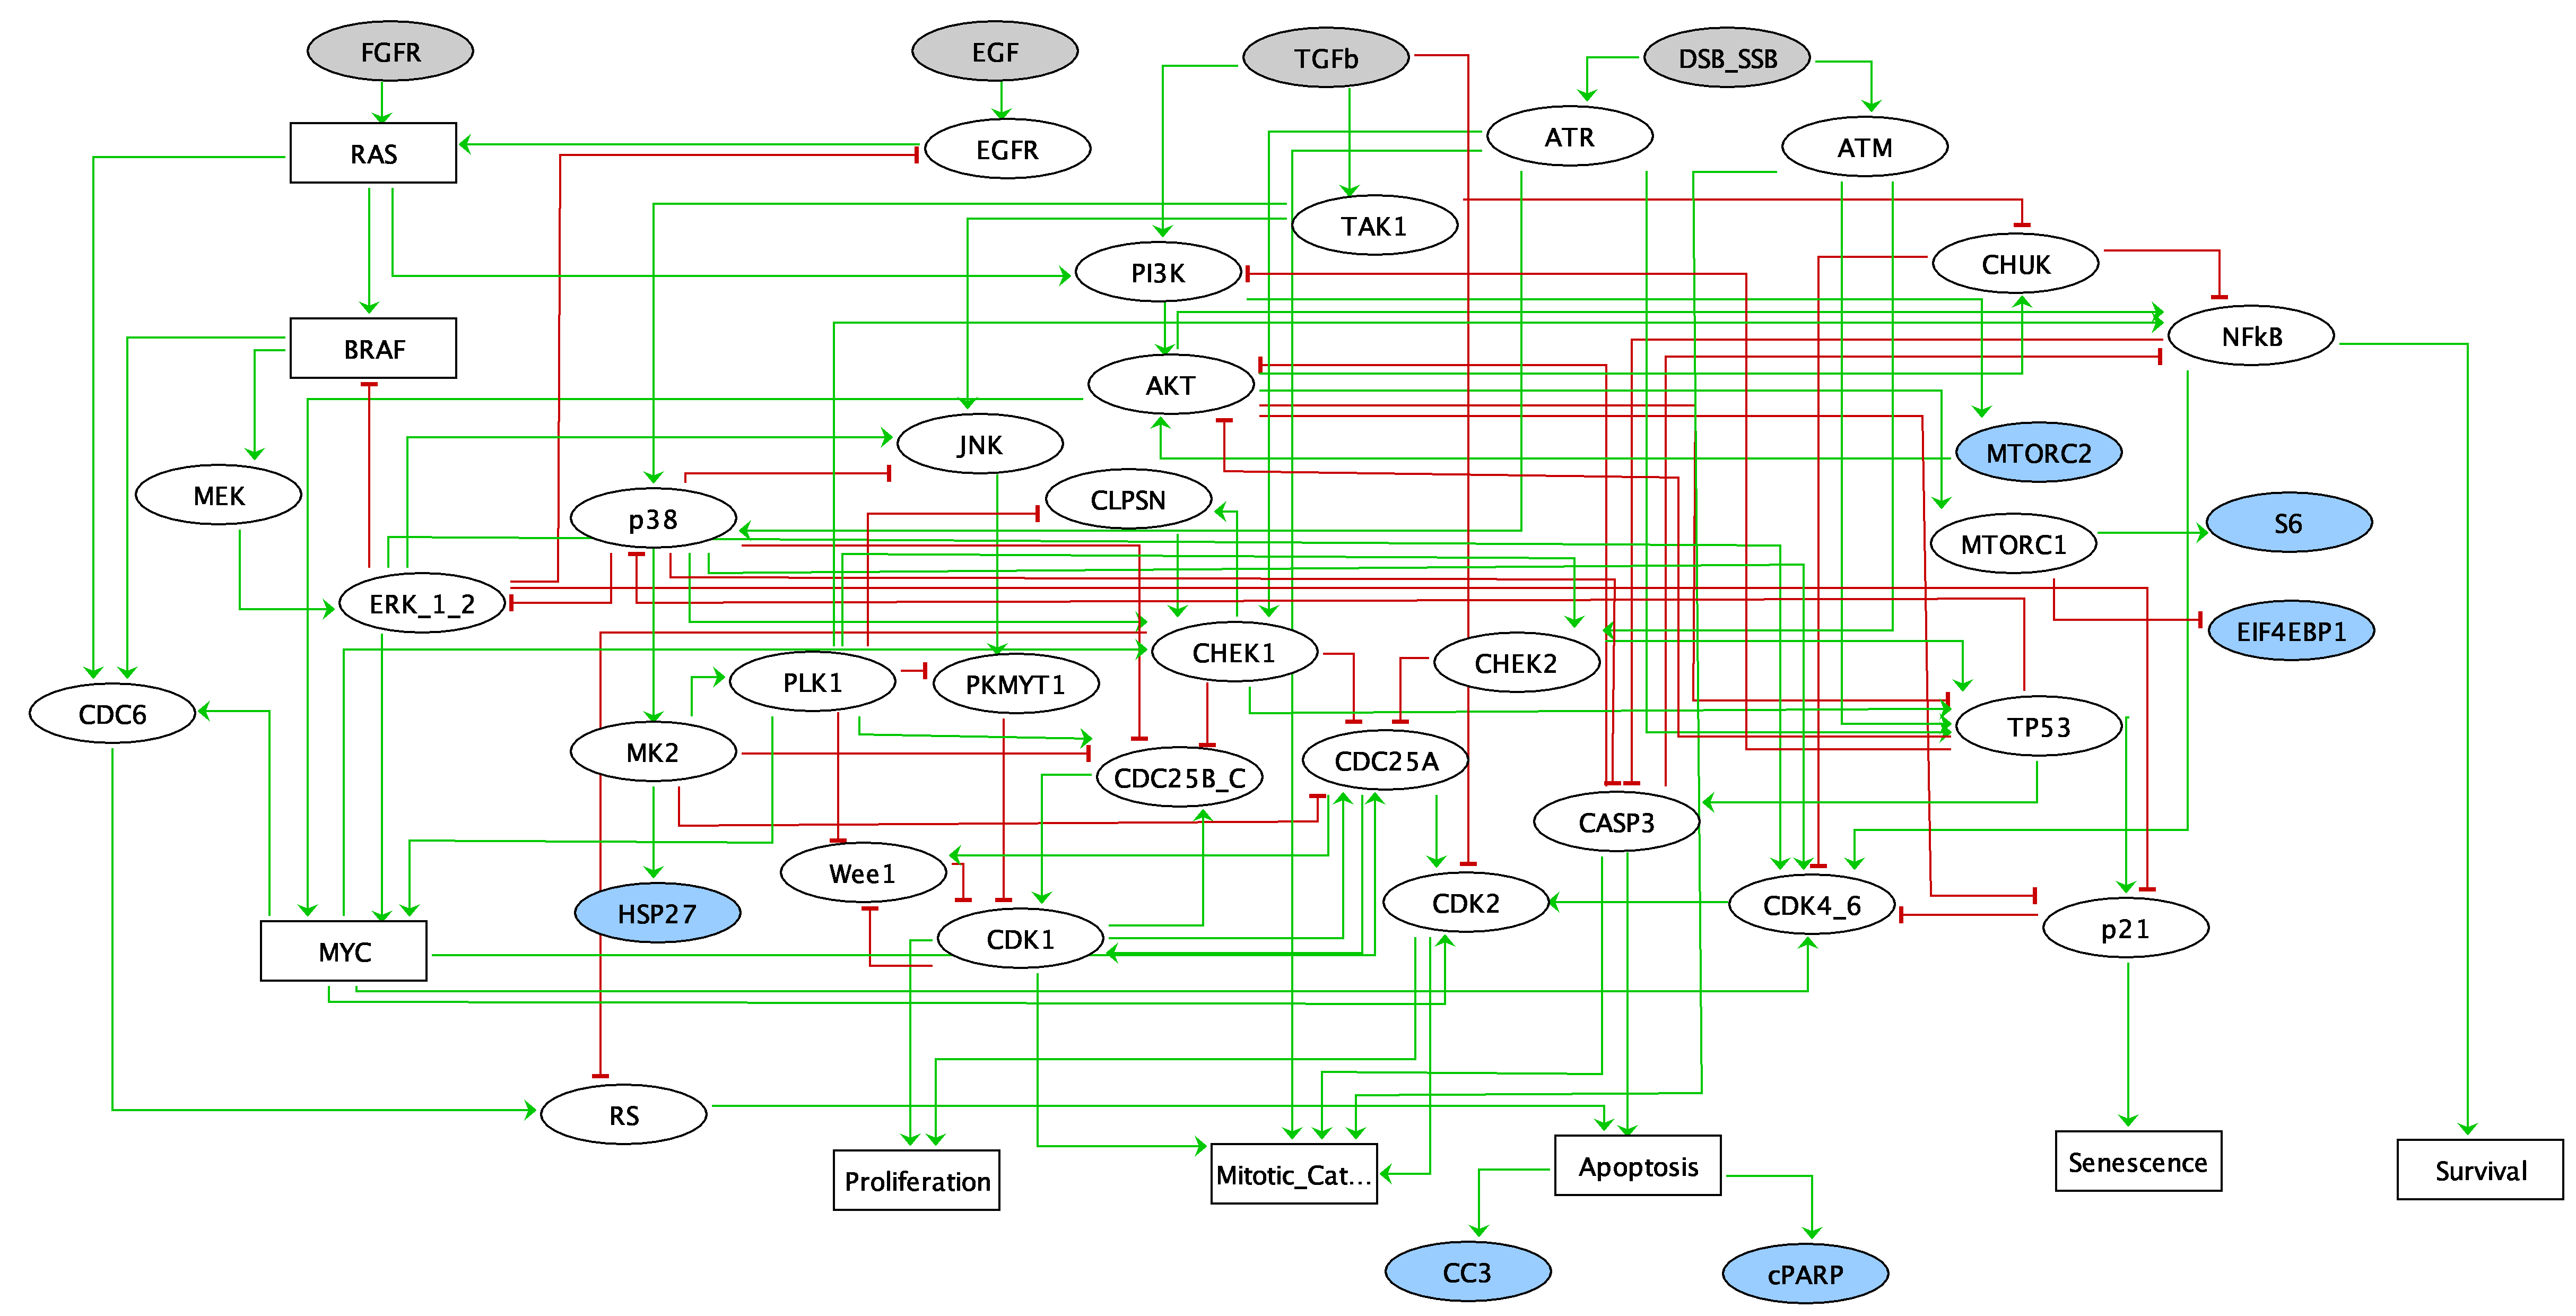

In [6]:
ginsim.show(ginsim_WT)

In this model, there is only one limit cycle governed by the megative feedback loop TP53 p38 and Chek1. We have also added an explicit node to account for replicative stress (RS) that is activated by oncogenic stress (mutations of oncogenes RAS and MYC). Oncogenic stress as a result of CyclinE mutations is not described here but could be accounted by CDK2 overexpression/mutation.

## MaBoSS simulation of the wild type model

Run MaBoSS now. The files used are:
*model.bnd* and *model.cfg*

In [7]:
## Set up the required files
bnd_file ="Charite.bnd"
cfg_WT = "Charite.bnd.cfg"

Load the model with either all 0s or random initial conditions and modify some configuration parameters. Note that if you used the export of GINsim export, all the initial values will be set to 0

In [8]:
## Load the Wild-Type model
WT = maboss.load(bnd_file, cfg_WT)

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':150})

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
#for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 EIF4EBP1 CHUK JNK AKT p38 p21 HSP27 cPARP CC3".split(' '):
     WT_allinputs.network[name].is_internal = True

Select the read-outs from the nodes of the model

Text(0.5, 1.0, 'WT pie chart')

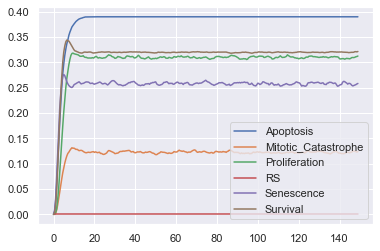

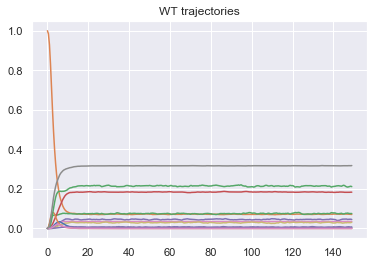

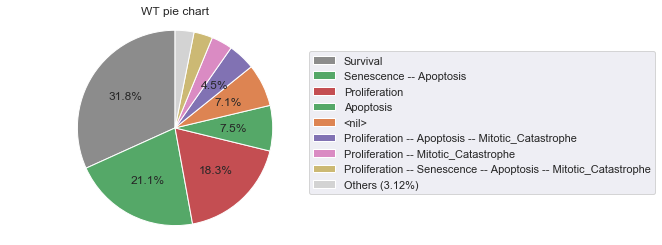

In [9]:
## Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))
#WT_allinputs.network.set_output(('CHEK1','CHEK2','AKT','MEK','NFkB','TP53','ERK_1_2','CASP3'))

WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
WT_allinputs.network.set_istate('DSB_SSB',[0.5,0.5])


## Run a MaBoSS simulation
run_WT_allinputs = WT_allinputs.run()

## Plot the results of the WT simulation
run_WT_allinputs.get_nodes_probtraj().plot(legend=True)
run_WT_allinputs.plot_trajectory(legend=False)
plt.title('WT trajectories')
# Plot pie chart
run_WT_allinputs.plot_piechart()
plt.title('WT pie chart')

# Simulations of different inputs

Simulations for different initial conditions as inputs ON 

In [10]:
## Model with different initial conditions
WT_cond1 = WT_allinputs.copy()

## To test combinations of inputs, include all lines
WT_cond1.network.set_istate('EGF', [0,1])
WT_cond1.network.set_istate('FGFR', [0,1])
WT_cond1.network.set_istate('TGFb', [1,0])
WT_cond1.network.set_istate('DSB_SSB', [1,0])

In [11]:
## Visualize only the selected phenotypes
WT_cond1.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe', 'Survival'))
run_cond1 = WT_cond1.run()

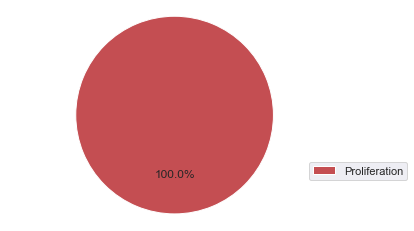

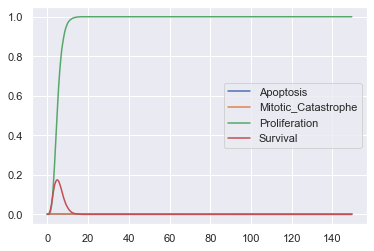

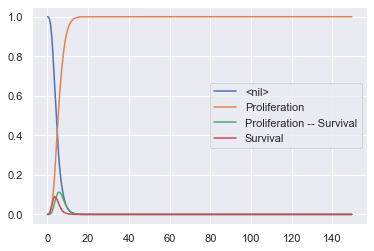

In [12]:
## Plot pie chart
run_cond1.plot_piechart()

## Plot the trajectories
run_cond1.get_nodes_probtraj().plot(legend=True)
run_cond1.get_states_probtraj().plot(legend=True)

We tested several combinations of inputs by changing initial conditions of the 4 inputs (the rest of the nodes are initially set to 0). In the case that there is no DNA damage but growth factors are ON, cells can proliferate and survive, but have a very low probability to trigger apoptosis. If TGFb is added, some apoptosis can be triggered. 

## Mutant simulations 

We test a simple gain of function mutation of BRAF which triggers some DNA damage but all other inputs are random 

Text(0.5, 1.0, 'BRAF mutant')

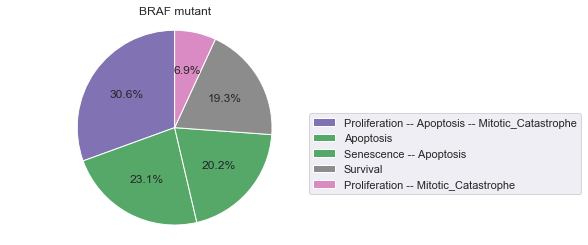

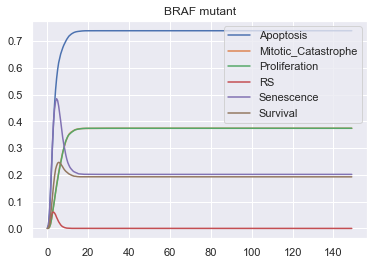

In [13]:
## Visualize only the selected phenotypes
#WT_allinputs.network.set_output(('CHEK1','CHEK2','AKT','MEK','NFkB','TP53','ERK_1_2','CASP3','cPARP'))
#WT_allinputs.network.set_output(('CDK1', 'CDK2','CASP3','NFkB','EGFR','TP53','MK2','CHEK1','AKT'))
WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])


## Gain of function for node 1
mut_BRAF_ON = WT_allinputs.copy()
mut_BRAF_ON.mutate("BRAF_b2", "ON")
mutres_BRAF_ON = mut_BRAF_ON.run()
mutres_BRAF_ON.plot_piechart()
plt.title('BRAF mutant')
mutres_BRAF_ON.get_nodes_probtraj().plot(legend=True)
plt.title('BRAF mutant')

Results: the cells can survive through NFkB. There is a safe mechanism triggered by replicative stress that activates cell death

Text(0.5, 1.0, 'KRAS mutant')

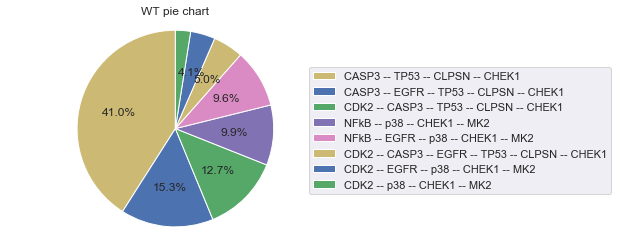

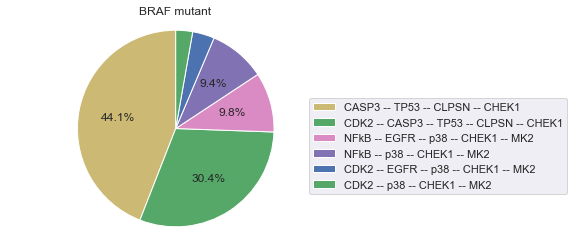

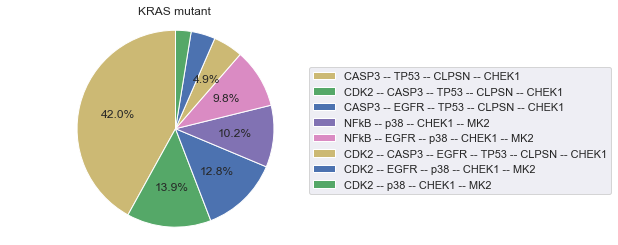

In [14]:
WT_allinputs.network.set_output(('CDK1', 'CDK2','CASP3','NFkB','EGFR','TP53','MK2','CHEK1','CLPSN','p38'))
run_WT_allinputs = WT_allinputs.run()

## Plot the results of the WT simulation
run_WT_allinputs.plot_piechart()
plt.title('WT pie chart')

WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])


## Gain of function for BRAF
mut_BRAF_ON = WT_allinputs.copy()
mut_BRAF_ON.mutate("BRAF_b2", "ON")
mutres_BRAF_ON = mut_BRAF_ON.run()
mutres_BRAF_ON.plot_piechart()
plt.title('BRAF mutant')

## Gain of function for KRAS
mut_KRAS_ON = WT_allinputs.copy()
mut_KRAS_ON.mutate("RAS_b2", "ON")
mutres_KRAS_ON = mut_KRAS_ON.run()
mutres_KRAS_ON.plot_piechart()
plt.title('KRAS mutant')

## Drug treatments on BRAF mutated cells

We tested the two CHEK1 and MK2 inhibitors on BRAF mutated cells

Text(0.5, 1.0, 'MK2i in KRAS mutants')

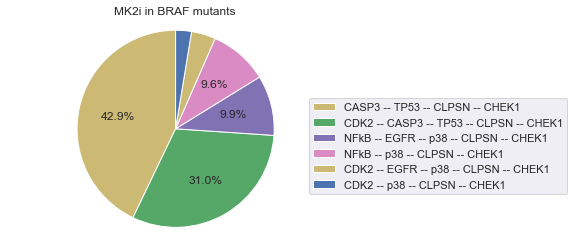

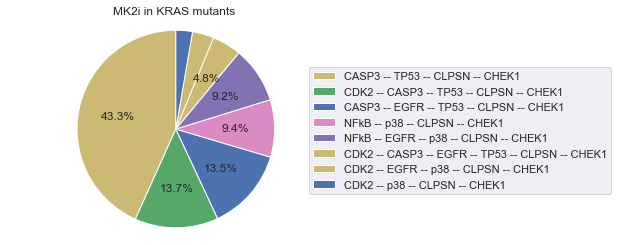

In [15]:
## Inhibition of MK2
mut_MK2i = mut_BRAF_ON.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
#plt.title('MK2i')
#mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i in BRAF mutants')


## Inhibition of MK2
mut_MK2i = mut_KRAS_ON.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
#plt.title('MK2i')
#mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i in KRAS mutants')

There is no noticeable effect of MK2 inhibitors in these BRAF mutated cells

CHEK1 inhibitors

Text(0.5, 1.0, 'CHEKi in KRAS mutants')

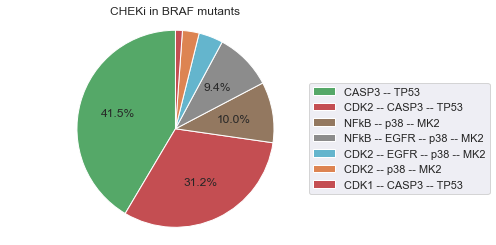

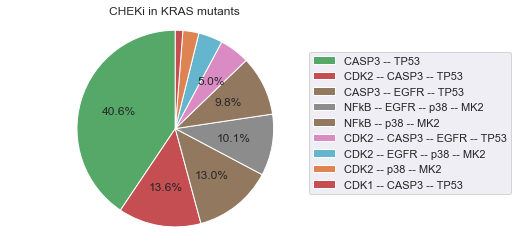

In [16]:
## Inhibition of CHEK1
mut_CHEKi = mut_BRAF_ON.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
#mut_CHEKi.mutate("CHEK2", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
#plt.title('CHEKi')
#mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi in BRAF mutants')

## Inhibition of CHEK1
mut_CHEKi = mut_KRAS_ON.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
#mut_CHEKi.mutate("CHEK2", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
#plt.title('CHEKi')
#mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi in KRAS mutants')

Survival is considerably reduced in response to CHEK1 inhibitors from 20% to less than 5%

We then tested if there existed some synergy between CHEK1 and MK2 inhibitors

Text(0.5, 1.0, 'MK2i CHEKi')

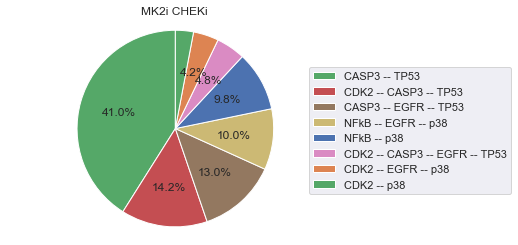

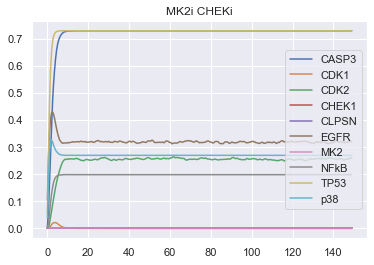

In [17]:
## Inhibition of CHEK1 and MK2
mut_CHEKi = mut_MK2i.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
#mut_CHEKi.mutate("CHEK2", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('MK2i CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i CHEKi')

There seems to be no synergy between the two drugs

## Drug treatments on cell lines

### Data

#### Mutation data

Some mutation data are available per cell line. Mutations reported for the key geens of interest are presented below. Note that mutation 1 to 4 corresponds to type of mutations but it is not modelled here. ** Data provided by the group of Christine Sers and Markus Morkel

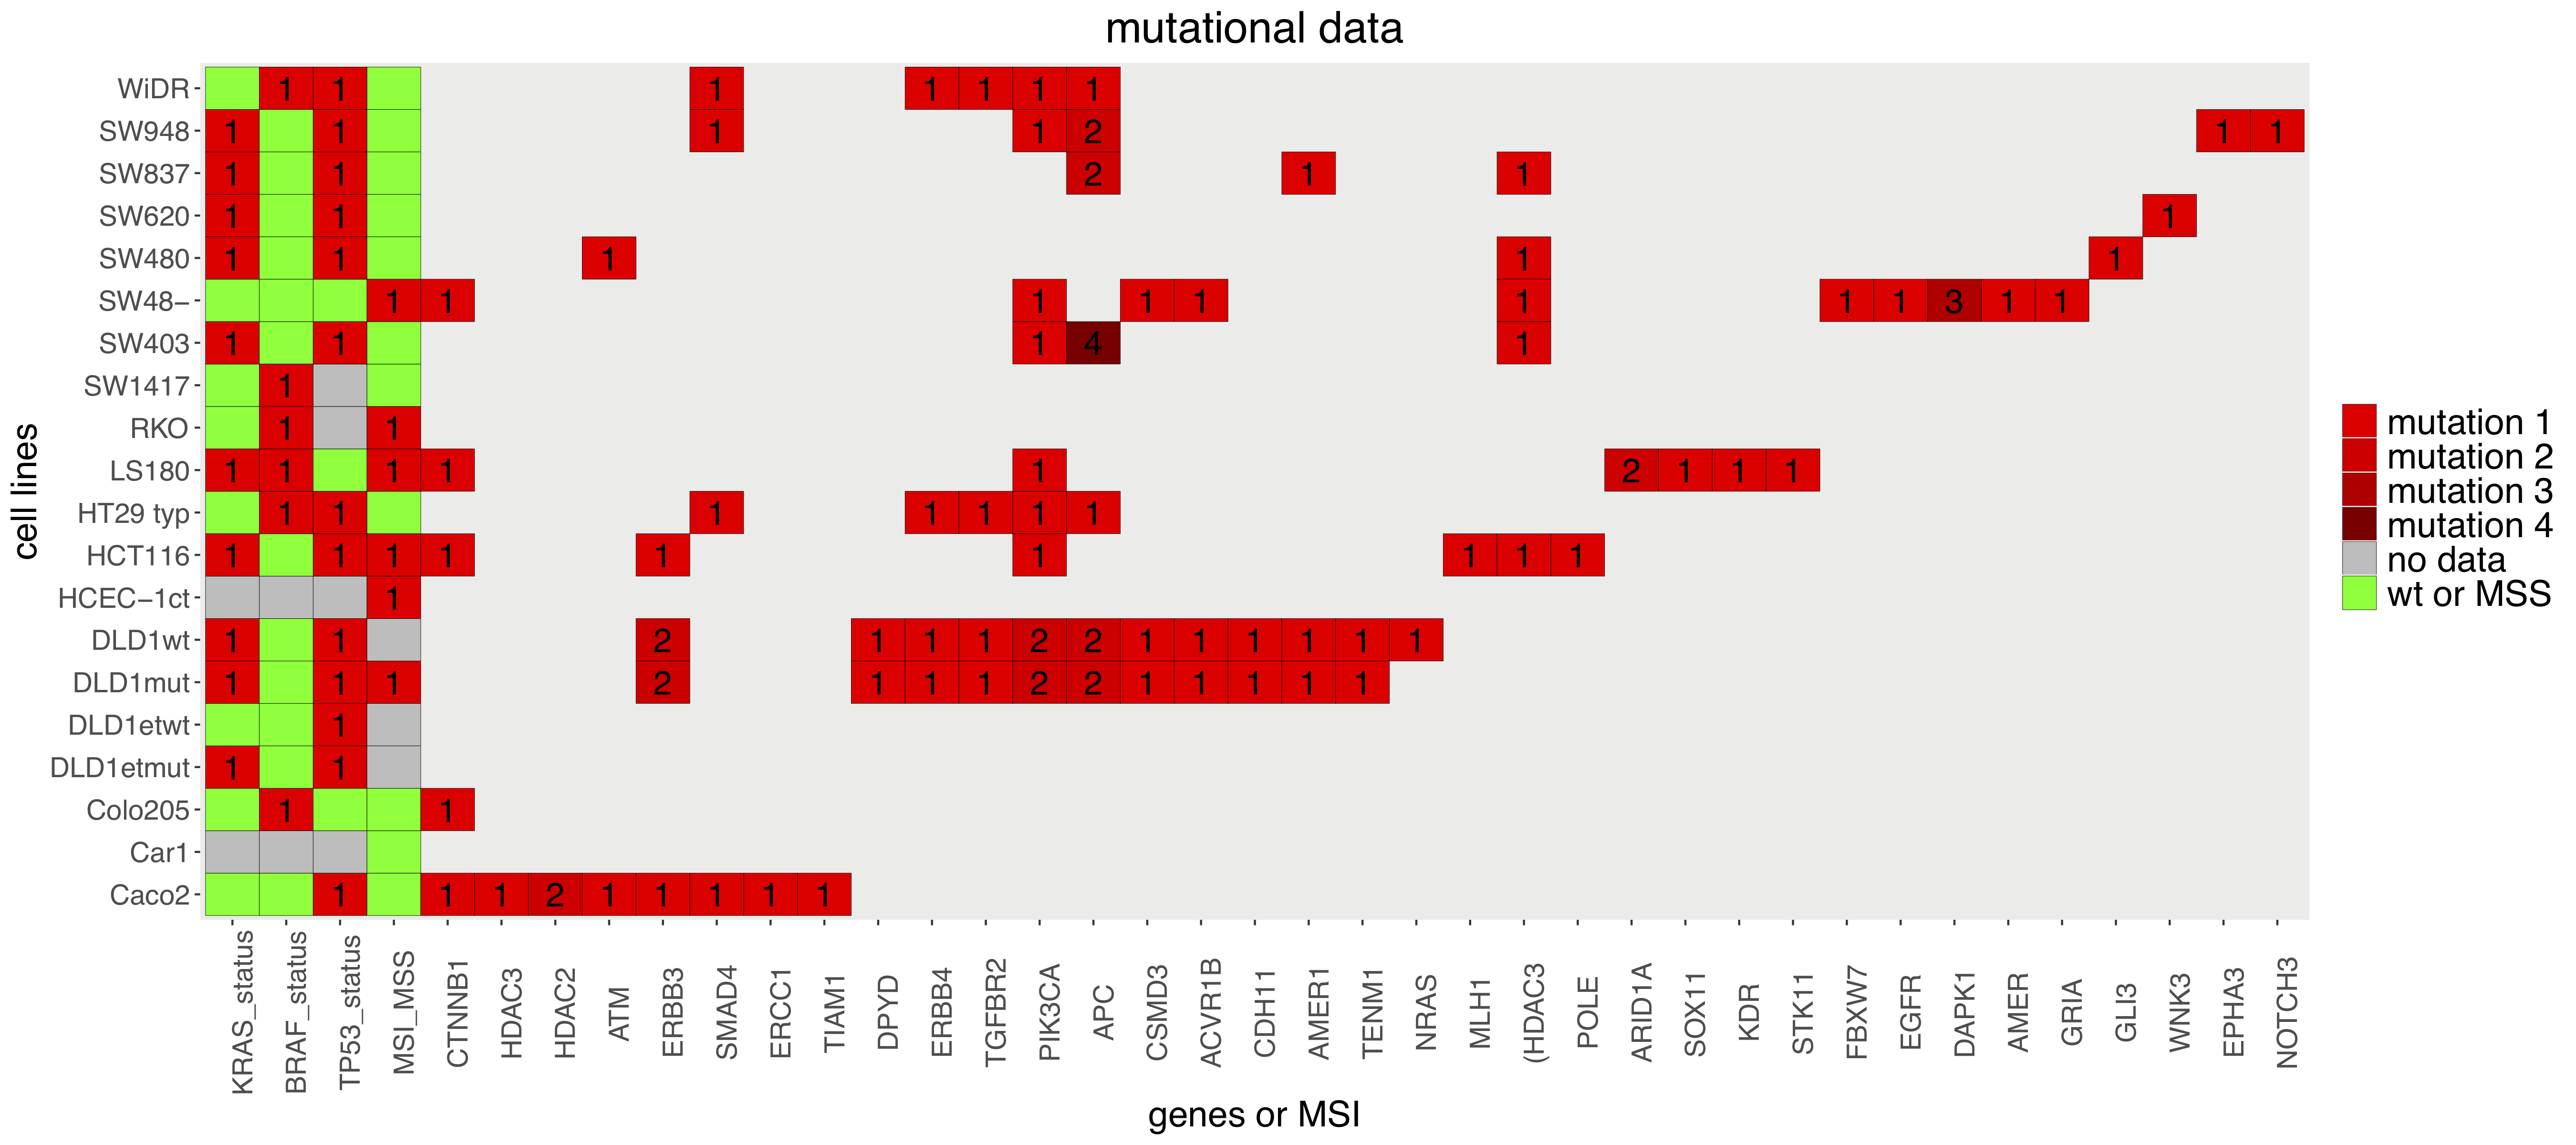

#### Cytof data for SW480 cell line

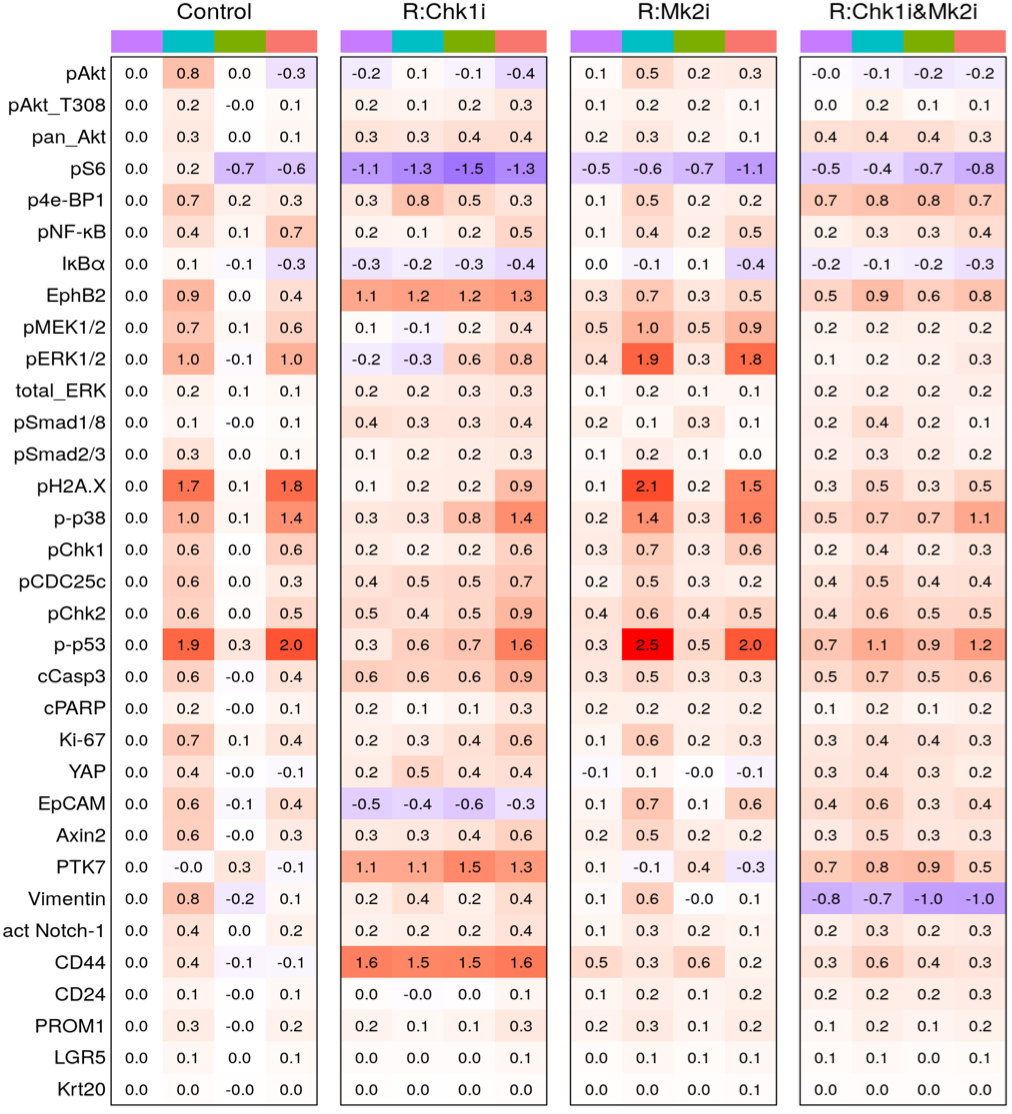

#### Cytof data for HT29 cell line

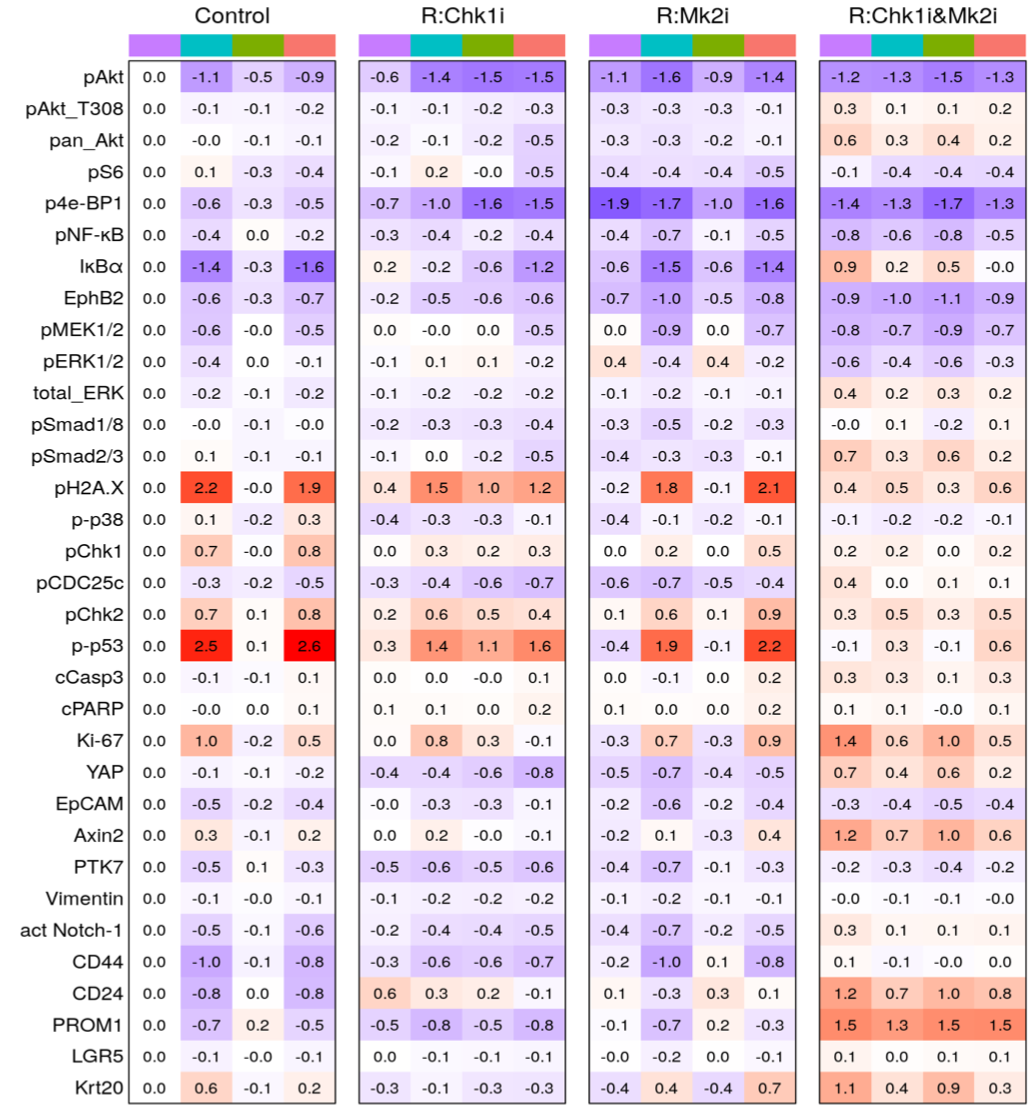

Cell lines are made resistant to the two inhibitors and to the combination of these inhibitors.

The cell lines are treated for 12 to 22 weeks and selected for their resistance. For example, for the control, they are named as follows: R:DMSO-D for resistant control not treated, R:DMSO-C for resistant chek1-treated control cells, R:DMSO-M for resistant mk2-treated control cells, and R:DMSO-CM for resistant chek1-mk2- treated control cells). 

Then on these four versions of resistant cell lines, some drug treatments are done:
(i) DMSO, (ii) 2,5 microM Chek1i, (iii) 2.5 microM Mk2i, and (iv) combination of both. 

Colors correspond to the level of activation of each protein (or phosphorylated protein) (red: FC = 4; white: FC = 0; blue: FC = -4).

The first experiment is the control (where cells are treated with DMSO), then the second shows the results of Chek1 inhibition, the third on Mek1 inhibitor, and the last one with the two drug inhibitors.


### Caco2 cell lines

Text(0.5, 1.0, 'Caco2')

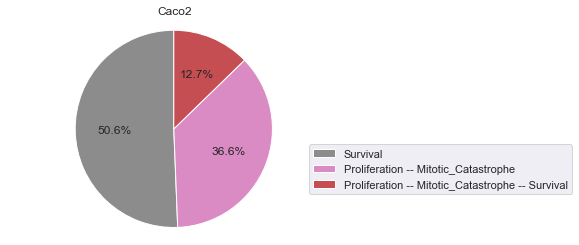

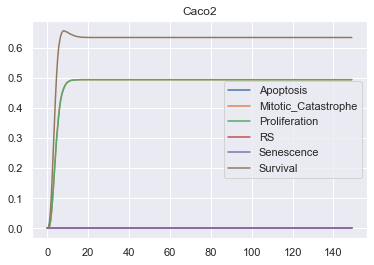

In [18]:
#WT_allinputs.network.set_output(('CHEK1','CHEK2','MEK','TP53','ERK_1_2','CASP3', 'Proliferation','Apoptosis'))
WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))
WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])


## Caco2 cell lines
mut_Caco2 = WT_allinputs.copy()
mut_Caco2.mutate("TP53", "OFF")
mutres_Caco2 = mut_Caco2.run()
mutres_Caco2.plot_piechart()
plt.title('Caco2')
mutres_Caco2.get_nodes_probtraj().plot(legend=True)
plt.title('Caco2')

Text(0.5, 1.0, 'MK2i CHEKi')

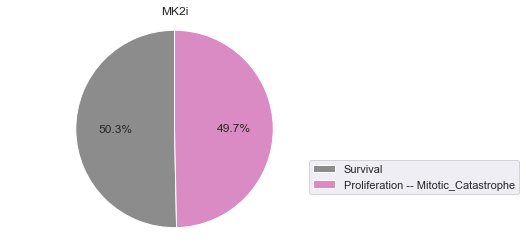

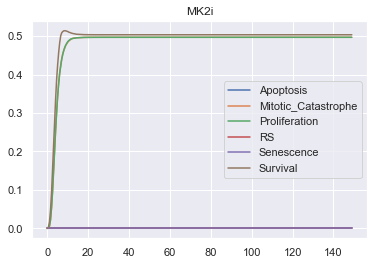

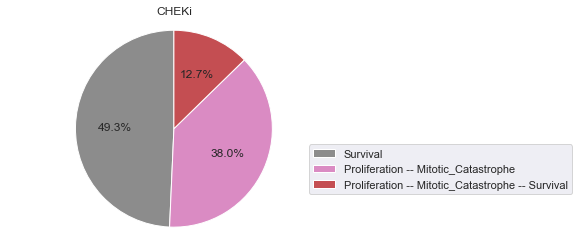

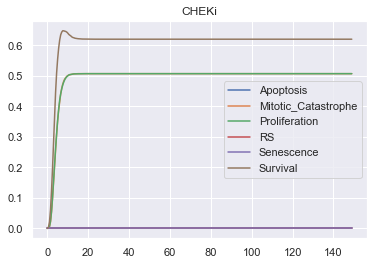

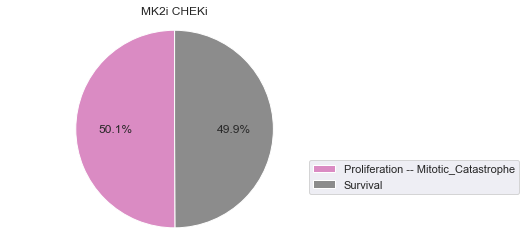

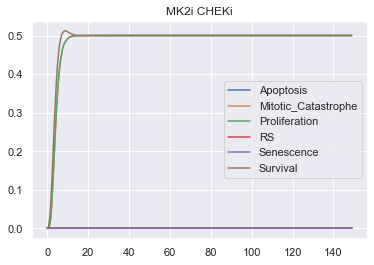

In [19]:
## Inhibition of MEK
mut_MK2i = mut_Caco2.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
plt.title('MK2i')
mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i')

## Inhibition of CHEK1
mut_CHEKi = mut_Caco2.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi')

## Inhibition of CHEK1 and MEK
mut_CHEKi = mut_MK2i.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('MK2i CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i CHEKi')

The two drugs have no effect on Caco2 cell lines

### SW620 cell line

Text(0.5, 1.0, 'SW620')

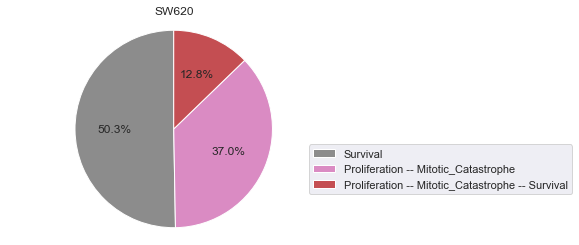

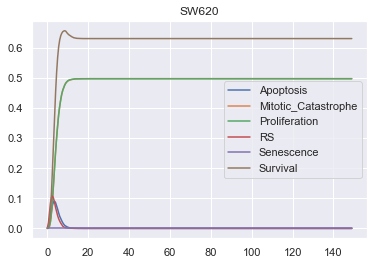

In [20]:
#WT_allinputs.network.set_output(('CHEK1','CHEK2','MEK','TP53','ERK_1_2','CASP3', 'Proliferation','Apoptosis'))
WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))
WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])


## SW620 cell lines
mut_SW620 = WT_allinputs.copy()
mut_SW620.mutate("RAS_b2", "ON")
mut_SW620.mutate("TP53", "OFF")
mutres_SW620 = mut_SW620.run()
mutres_SW620.plot_piechart()
plt.title('SW620')
mutres_SW620.get_nodes_probtraj().plot(legend=True)
plt.title('SW620')

Text(0.5, 1.0, 'MK2i CHEKi')

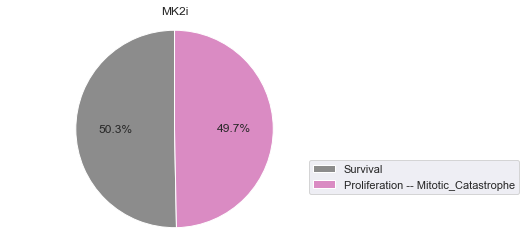

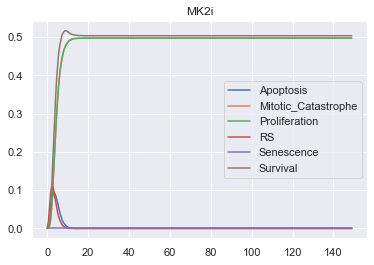

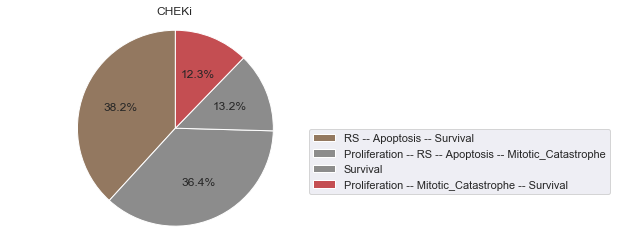

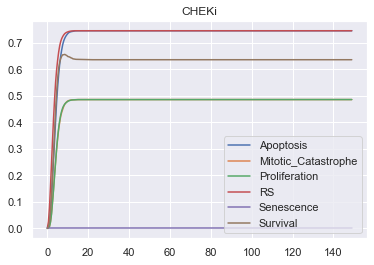

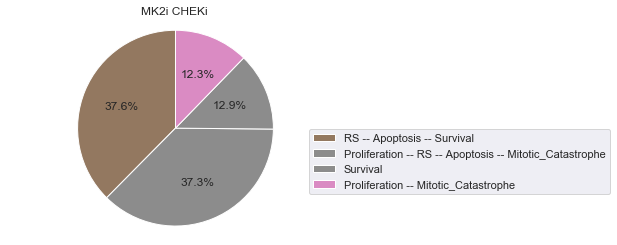

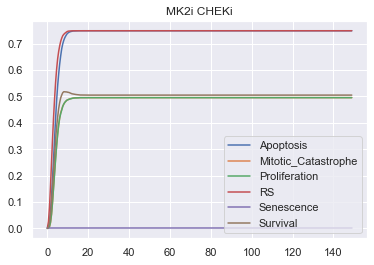

In [21]:
## Visualize only the selected phenotypes
#mut_SW620.network.set_output(('CHEK1','CHEK2','MEK','TP53','ERK_1_2','CASP3', 'Proliferation','Apoptosis'))
#mut_SW620.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))

## Inhibition of MEK
mut_MK2i = mut_SW620.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
plt.title('MK2i')
mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i')

## Inhibition of CHEK1
mut_CHEKi = mut_SW620.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi')

## Inhibition of CHEK1 and MEK
mut_CHEKi = mut_MK2i.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('MK2i CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i CHEKi')

MK2i has little effect on this cell line. However, Chek1 inhibitors seems to trigger apoptosis by releasing the hold that Chek1 had on replicative stress

### HT29 cell line

Text(0.5, 1.0, 'HT29')

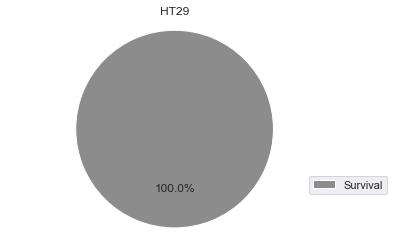

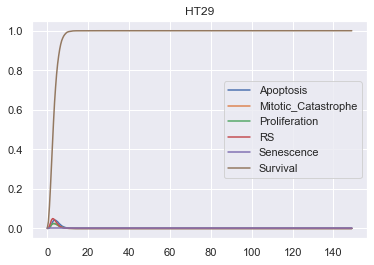

In [22]:
#WT_allinputs.network.set_output(('CHEK1','CHEK2','MEK','TP53','ERK_1_2','CASP3', 'Proliferation','Apoptosis'))
WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))
WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0,1])

## HT29 cell lines
mut_HT29 = WT_allinputs.copy()
#mut_HT29.mutate("RAS_b2", "ON")
mut_HT29.mutate("BRAF_b2", "ON")
mut_HT29.mutate("PI3K", "ON")
#mut_HT29.mutate("TGFb", "ON")
mut_HT29.mutate("TP53", "OFF")
mutres_HT29 = mut_HT29.run()
mutres_HT29.plot_piechart()
plt.title('HT29')
mutres_HT29.get_nodes_probtraj().plot(legend=True)
plt.title('HT29')

Text(0.5, 1.0, 'MK2i CHEKi')

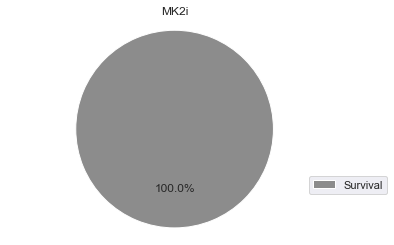

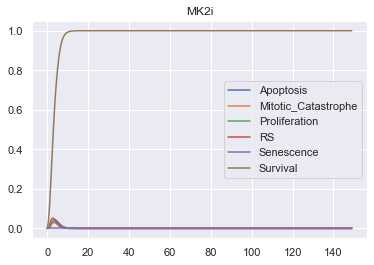

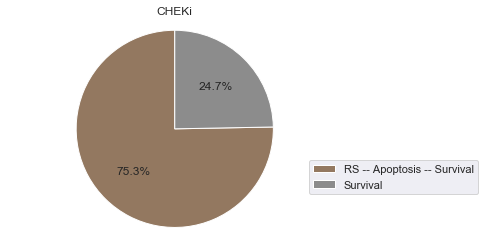

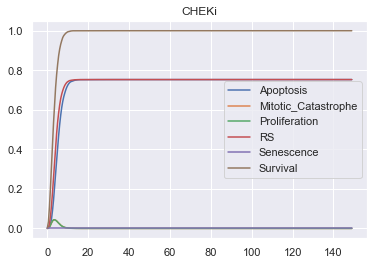

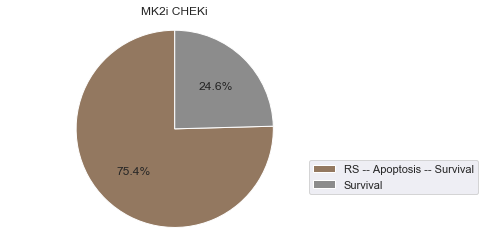

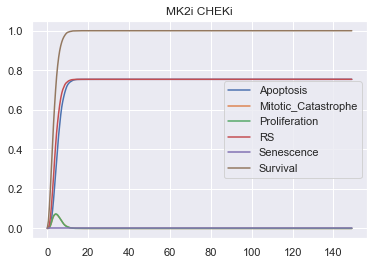

In [23]:
## Inhibition of MEK
mut_MK2i = mut_HT29.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
plt.title('MK2i')
mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i')

## Inhibition of CHEK1
mut_CHEKi = mut_HT29.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi')

## Inhibition of CHEK1 and MEK
mut_CHEKi = mut_MK2i.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('MK2i CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i CHEKi')

The effect of Chek1 inhibitors in HT29 cell lines seem to go through other pathways than those of SW620. TGFb pathway seems to favor survival pathway

### SW480 cell line

Text(0.5, 1.0, 'SW480')

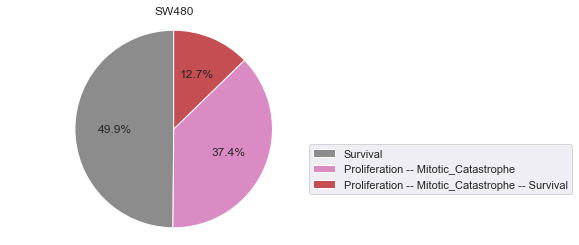

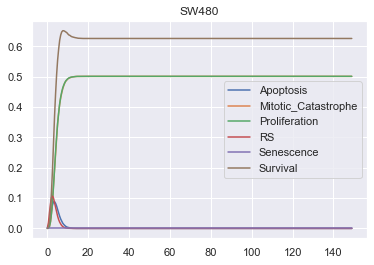

In [24]:
#WT_allinputs.network.set_output(('CHEK1','CHEK2','MEK','TP53','ERK_1_2','CASP3', 'Proliferation','Apoptosis'))
WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis','Mitotic_Catastrophe','Survival', 'RS'))
WT_allinputs.network.set_istate('DSB_SSB',[0,1])
WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])


## SW480 cell lines
mut_SW480 = WT_allinputs.copy()
mut_SW480.mutate("RAS_b2", "ON")
#mut_SW480.mutate("BRAF_b2", "ON")
mut_SW480.mutate("ATM", "ON")
#mut_SW480.mutate("TGFb", "ON")
mut_SW480.mutate("TP53", "OFF")
mutres_SW480 = mut_SW480.run()
mutres_SW480.plot_piechart()
plt.title('SW480')
mutres_SW480.get_nodes_probtraj().plot(legend=True)
plt.title('SW480')

Text(0.5, 1.0, 'MK2i CHEKi')

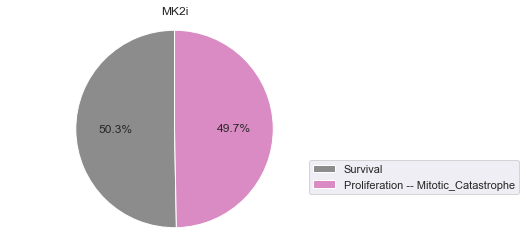

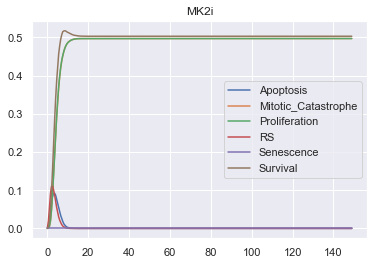

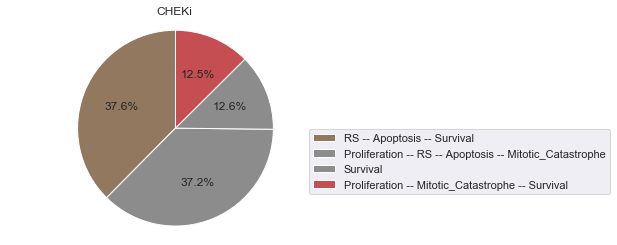

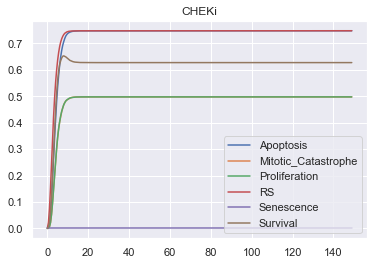

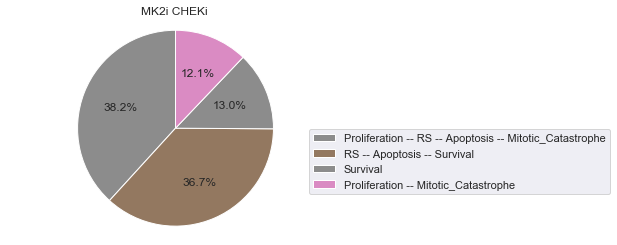

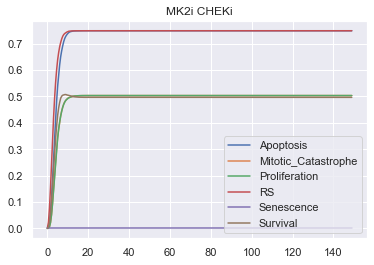

In [25]:
## Inhibition of MEK
mut_MK2i = mut_SW480.copy()
mut_MK2i.mutate("MK2", "OFF")
mutres_MK2i = mut_MK2i.run()
mutres_MK2i.plot_piechart()
plt.title('MK2i')
mutres_MK2i.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i')

## Inhibition of CHEK1
mut_CHEKi = mut_SW480.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi')

## Inhibition of CHEK1 and MEK
mut_CHEKi = mut_MK2i.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('MK2i CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('MK2i CHEKi')

With only mutation profiles, we are not able to differentiate the effect of SW620 and SW480 cell lines. Experiments seem to suggest that SW480 cell lines are not as sensitive to Chek1 inhibitor treatments than SW620 cell lines

### Model verification ==> TO DO

In [26]:
#import maboss
#import maboss_test
#from IPython.display import Image

In [27]:
#test = maboss_test.MaBoSSTestCase(mut_SW620)

In [28]:
#SW620_Cheki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':0}
#SW620_Mk2i = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':0}
#SW620_Cheki_Mk2i = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}


#SW480_Cheki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#SW480_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#SW480_Cheki_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}

#HCT116_Cheki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#HCT116_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#HCT116_Cheki_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}

#Caco2_Cheki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#Caco2_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}
#Caco2_Cheki_Meki = {'CHEK2':1, 'CASP3':1,'cPARP':1,'ERK_1_2':1, 'MEK1':1, 'AKT':1, 'p38':1, 'Proliferation':1, 'NFkB':1, 'TP53':1, 'S6':1}


In [29]:
#test.assertStableStateProbabilityEvolution({'CHEK1':'OFF'},{}, 'SW620_Cheki','increase')
#test.assertStableStateProbabilityEvolution({'MK2':'OFF'},{}, SW620_Mk2i,'decrease')
#test.assertStableStateProbabilityEvolution({'CHEK1':'OFF','MK2':'OFF'},{}, SW620_Cheki_Mk2i,'increase')

## Automatic single mutant simulations

NB: This step needs to be adapted. If you sleect too many nodes, there will be too many plots and the notebook may not handle it. 

In [30]:
#import matplotlib.pyplot as plt # for customizing the plots

### Simulation of simple inhibition

Text(0.5, 1.0, 'CHEKi')

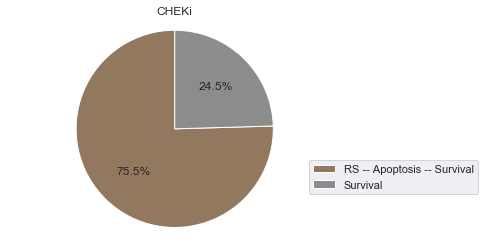

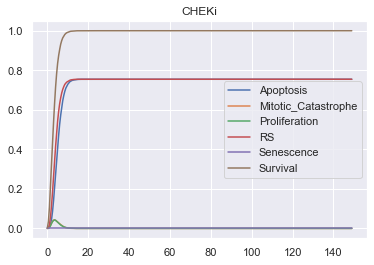

In [31]:
## If you wish to exclude only some nodes from the all list of variables:
#excluded = set( ('FGFR', 'IGFR', 'EGF', 'DSB_SSB', 'Apoptosis','Proliferation','Senescence', 'HSP27','ROS','ELK_FOS','cPARP','CC3', 'EIF4EBP1','S6','MTORC2') )
#nodes = [ n for n in WT_allinputs.network.names if n not in excluded ]
#nodes.sort()

## if you wish to ony select few nodes:
nodes = ['CLPSN','PLK1','p38','ERK_1_2', 'TAK1', 'CHUK']

## Inhibition of CHEK1
mut_CHEKi = mut_HT29.copy()
mut_CHEKi.mutate("CHEK1", "OFF")
mutres_CHEKi = mut_CHEKi.run()
mutres_CHEKi.plot_piechart()
plt.title('CHEKi')
mutres_CHEKi.get_nodes_probtraj().plot(legend=True)
plt.title('CHEKi')


#WTallinputs.set_output(('Proliferation','Apoptosis', 'NFkB'))

CLPSN PLK1 p38 ERK_1_2 TAK1 CHUK 

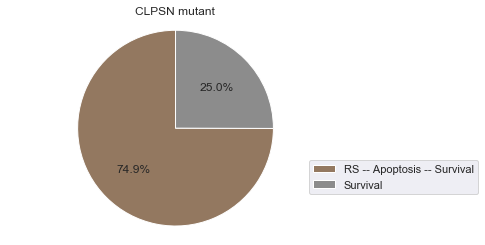

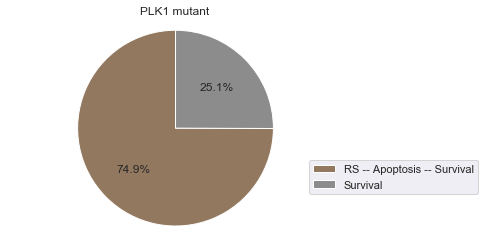

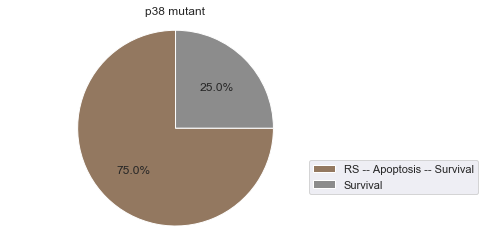

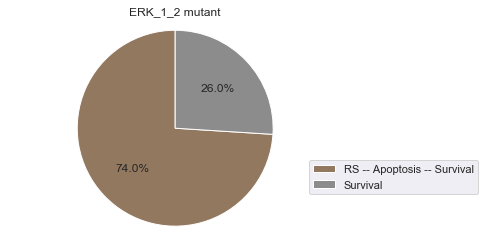

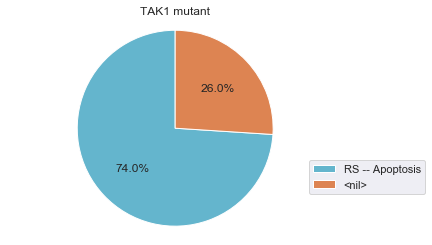

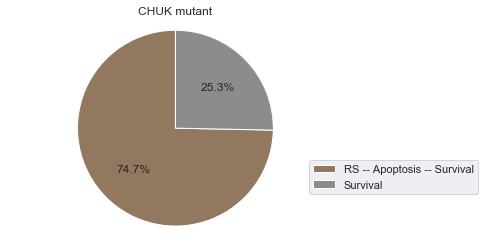

In [32]:
# Simulate genes with loss of function
for mutant in nodes:
    print(mutant, end=' ')
    mut_sim = mut_CHEKi.copy()
    mut_sim.mutate(mutant, "OFF")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    plt.title("%s mutant" % mutant)

CLPSN PLK1 p38 ERK_1_2 TAK1 CHUK 

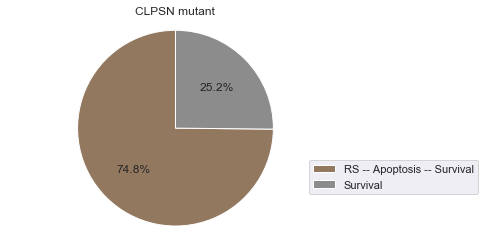

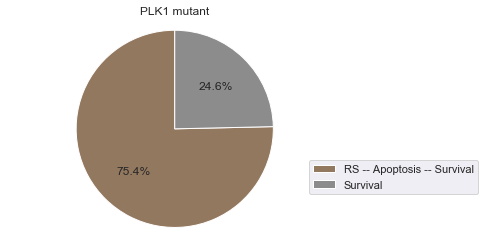

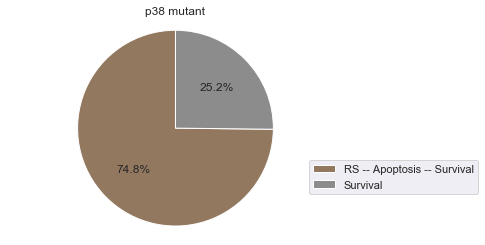

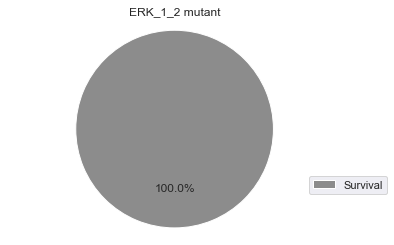

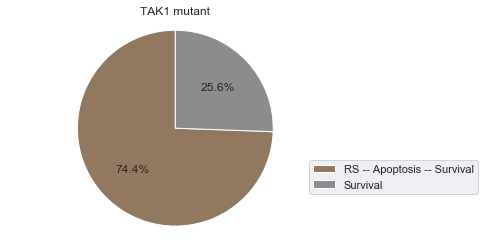

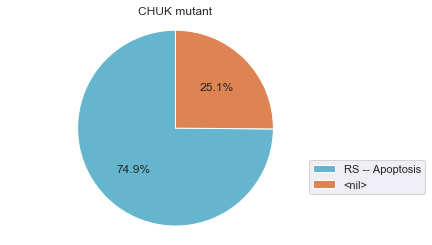

In [33]:
# Simulate genes with loss of function
for mutant in nodes:
    print(mutant, end=' ')
    mut_sim = mut_CHEKi.copy()
    mut_sim.mutate(mutant, "ON")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    plt.title("%s mutant" % mutant)

### Double mutation experiments

In [34]:
# Libraries for creating combinations of mutants
#from itertools import combinations
#from functools import reduce

# Create double mutants
#mutant_combinations = [combinations(m.items(), 2) for m in mutant if len(m) >= 2]
#combinations = reduce(set.union, mutant_combinations, set())
#combinations

# Simulate double mutants
#for mutant in sorted(combinations):
#    mut_sim_double = WT_allinputs.copy()
#    for (node, value) in mutant:
#        mut_sim_double.mutate(node, "ON" if value else "OFF")
#    mut_double_res = mut_sim_double.run()
#    mut_double_res.plot_piechart(embed_labels=False, autopct=4)
#    mutant_name = "/".join(["%s:%s"%m for m in mutant])
#    plt.title("%s mutant" % mutant_name)